# RANSAC Algorithm

# Load data
This is just a reuse of the Sklearn example:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html


Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


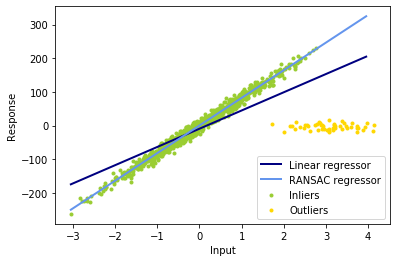

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

# RANSAC

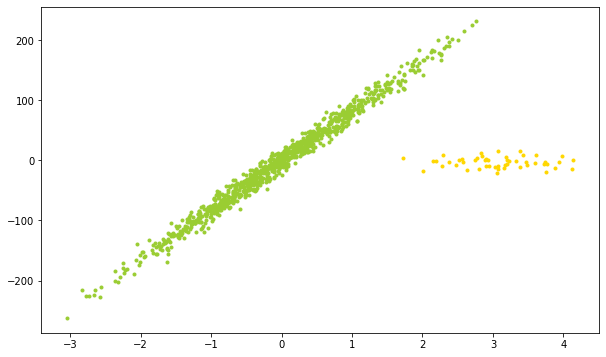

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.show()

**Compute residual threshold**

According to sklearn documentation, the residual threshold for RANSAC is mean absolute deviation (MAD) of y.

In [10]:
from scipy import stats
import numba

In [9]:
residual_threshold = stats.median_abs_deviation(y)
print(f"Residual threshold is {residual_threshold}.")

Residual threshold is 51.064948575086504.


In [19]:
n_samples = len(y)

# Explore

In [20]:
@numba.njit()
def one_run(i, j):
    # build a model with Point I and Point J
    slope = (y[i] - y[j]) / (X[i][0] - X[j][0])
    # y = ax + b
    # b = y - ax
    intercept = y[i] - slope * X[i][0]
    
    # Count number of inliers
    
    n_inliers = 0
    for k in range(n_samples):
        y_hat = slope * X[k][0] + intercept
        if y[k] > y_hat - residual_threshold and y[k] < y_hat + residual_threshold:
            n_inliers += 1
    
    return slope, intercept, n_inliers
    

In [23]:
slope, intercept, n_inliers = one_run(1, 2)
print(f"Slope: {slope}, Intercept: {intercept}, and #Inliers: {n_inliers}") 

Slope: -31.031367548715302, Intercept: 100.17184032979411, and #Inliers: 260


In [28]:
def plot_one_run(slope, intercept):
    y_hat = [slope * x[0] + intercept for x in X]
    y_upper = y_hat - residual_threshold
    y_lower = y_hat + residual_threshold
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
                label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
                label='Outliers')
    
    plt.plot(X, y_hat, color='black', label="fitted line")
    plt.plot(X, y_upper, color='blue', label="upper bound")
    plt.plot(X, y_lower, color='blue', label="lower bound")
    plt.legend()
    plt.show()

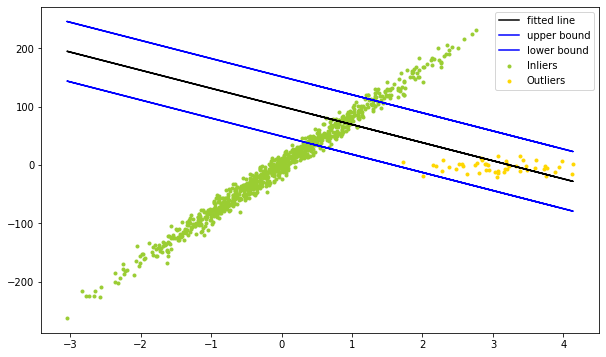

In [29]:
plot_one_run(slope, intercept)

Slope: 87.42882074717447, Intercept: -2.2013221925125954, and #Inliers: 950


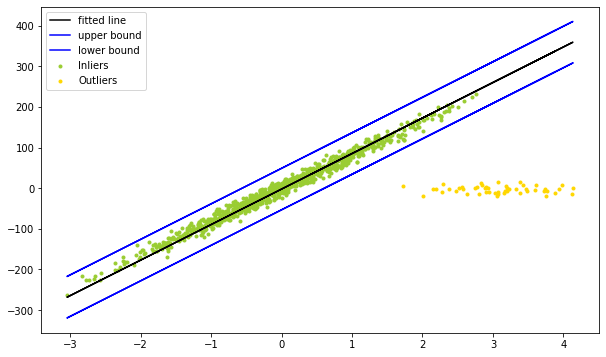

In [32]:
slope, intercept, n_inliers = one_run(100, 200)
print(f"Slope: {slope}, Intercept: {intercept}, and #Inliers: {n_inliers}") 
plot_one_run(slope, intercept)

# Put it together


In [44]:
@numba.njit()
def ransac(X, y):
    n_samples = len(y)
    max_n_inliers = 0
    best_slope = 0
    best_intercept = 0
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            slope, intercept, n_inliers = one_run(i, j)
            if n_inliers > max_n_inliers:
                max_n_inliers = n_inliers
                best_slope = slope
                best_intercept = intercept
    return best_slope, best_intercept, max_n_inliers

In [45]:
slope, intercept, n_inliers = ransac(X, y)
print(slope, intercept, n_inliers)

87.57000794220923 9.21368949332684 950


In [46]:
y_my_ransac = slope * X[:,0] + intercept

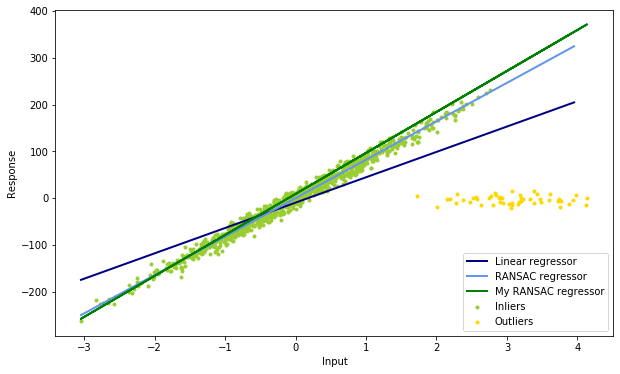

In [48]:
lw = 2
plt.figure(figsize=(10, 6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.plot(X, y_my_ransac, color='green', linewidth=lw,
         label='My RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()